In [127]:
import plotly.graph_objects as go
from tabulate import tabulate
import mlos_core.optimizers
import ConfigSpace as CS
from ConfigSpace import UniformIntegerHyperparameter
from ConfigSpace import UniformFloatHyperparameter
from ConfigSpace import CategoricalHyperparameter
import pandas as pd
import plotly.express as px
import os
import time
import sys
import logging
import matplotlib.pyplot as plt
import numpy as np

In [128]:
log_file_path = '../../build/logs/mlos_logger.txt'
try:
    logging.basicConfig(filename='../../build/logs/mlos_logger.txt',
                    filemode='a',
                    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.INFO)


    logger = logging.getLogger('mlosLogger')
    logger.info("Running mlos")
    pd.set_option('display.max_columns', None)
except Exception as e:
    print(f"Error occurred while configuring logger: {e}")

In [129]:
def cost_model(i):
    performance_data = pd.read_csv('../../build/performance/performance_metrics.csv', header=None) #throughput
    return performance_data.iloc[i-2:,8].mean()

In [130]:
default_values = {
    "max_background_jobs": 2,
    "max_subcompactions": 1,
    "max_write_buffer_number":2,
    "level0_slowdown_writes_trigger": 20,
    "level0_stop_writes_trigger": 36,
    "target_file_size_base": 64 * 1048576,
    "target_file_size_multiplier": 1,
    "max_bytes_for_level_multiplier": 10,
    "write_buffer_size": 64 << 20,
    "level0_file_num_compaction_trigger": 4,
    "max_bytes_for_level_base": 256 * 1048576,
    "score":0
}


In [131]:
input_space = CS.ConfigurationSpace(seed=1234)

max_open_files=CS.Integer("max_open_files",(-1,1000),default=-1)
max_total_wal_size=CS.Integer("max_total_wal_size",(0,1000))
delete_obsolete_files_period_micros=CS.Integer("delete_obsolete_files_period_micros",(1,1000 * 60 * 60 * 1000000),default=6 * 60 * 60 * 1000000)

max_background_jobs=CS.Integer("max_background_jobs", (1,20), default=default_values["max_background_jobs"])
max_subcompactions=CS.Integer("max_subcompactions", (1,20), default=default_values["max_subcompactions"])
compaction_readahead_size=CS.Integer("compaction_readahead_size",(0,1000 * 1024 * 1024),default=2 * 1024 * 1024)

writable_file_max_buffer_size=CS.Integer("writable_file_max_buffer_size",(0,1000*1024*1024),default=1024 * 1024)
delayed_write_rate=CS.Integer("delayed_write_rate",(0,1000*1024*1024),default=0)
avoid_flush_during_shutdown=CS.Categorical("avoid_flush_during_shutdown", ["true","false"], default="true") 

max_write_buffer_number=CS.Integer("max_write_buffer_number", (1,10), default=default_values["max_write_buffer_number"])
inplace_update_num_locks=CS.Integer("inplace_update_num_locks",(0,100000),default=10000)
memtable_prefix_bloom_size_ratio=CS.Float("memtable_prefix_bloom_size_ratio",(0.0,1.0),default=0)

memtable_whole_key_filtering=CS.Categorical("memtable_whole_key_filtering",["true","false"], default="false") 
memtable_huge_page_size=CS.Integer("memtable_huge_page_size",(0,1000 * 1024 * 1024),default=0)
arena_block_size=CS.Integer("arena_block_size",(0, 2<<30),default=0)

# compression_per_level=CS.("compression_per_level")
level0_slowdown_writes_trigger=CS.Integer("level0_slowdown_writes_trigger", (1,25), default=default_values["level0_slowdown_writes_trigger"]) 
level0_stop_writes_trigger=CS.Integer("level0_stop_writes_trigger", (1,50), default=default_values["level0_stop_writes_trigger"]) 

target_file_size_base=CS.Integer("target_file_size_base", (1,100 * 1048576), default=default_values["target_file_size_base"])
target_file_size_multiplier=CS.Integer("target_file_size_multiplier", (1,10), default=default_values["target_file_size_multiplier"])
max_bytes_for_level_multiplier=CS.Integer("max_bytes_for_level_multiplier", (2,20), default=default_values["max_bytes_for_level_multiplier"])

write_buffer_size=CS.Float("write_buffer_size",(20<<20,80<<20),default=default_values["write_buffer_size"])
level0_file_num_compaction_trigger=CS.Integer("level0_file_num_compaction_trigger",(-1,10),default=default_values["level0_file_num_compaction_trigger"])
max_bytes_for_level_base=CS.Integer("max_bytes_for_level_base",(128 * 1048576,512 * 1048576),default=default_values["max_bytes_for_level_base"])

# max_bytes_for_level_multiplier_additional=CS.("max_bytes_for_level_multiplier_additional")
# max_compaction_bytes=CS.Integer("max_compaction_bytes")
# soft_pending_compaction_bytes_limit=CS.Integer("soft_pending_compaction_bytes_limit")

# hard_pending_compaction_bytes_limit=CS.Integer("hard_pending_compaction_bytes_limit")
# compaction_options_universal=CS.("compaction_options_universal")
# compaction_options_fifo=CS.("compaction_options_fifo")

max_sequential_skip_in_iterations=CS.Integer("max_sequential_skip_in_iterations",(0,999999),default=8)
max_successive_merges=CS.Integer("max_successive_merges",(0,1000),default=0)
check_flush_compaction_key_order=CS.Categorical("check_flush_compaction_key_order",["true","false"], default="true") 

paranoid_file_checks=CS.Categorical("paranoid_file_checks",["true","false"], default="false") 
report_bg_io_stats=CS.Categorical("report_bg_io_stats",["true","false"], default="false") 
# ttl=CS.Integer("ttl")

# periodic_compaction_seconds=CS.Integer("periodic_compaction_seconds")
# bottommost_temperature=CS.("bottommost_temperature")
enable_blob_files=CS.Categorical("enable_blob_files",["true","false"], default="false") 

min_blob_size=CS.Integer("min_blob_size",(0,1024),default=0)
# blob_file_size=CS.Integer("blob_file_size")
# blob_compression_type=CS.("blob_compression_type")

enable_blob_garbage_collection=CS.Categorical("enable_blob_garbage_collection",["true","false"], default="false") 
blob_garbage_collection_age_cutoff=CS.Float("blob_garbage_collection_age_cutoff",(0.0,1.0),default=0.25)
blob_garbage_collection_force_threshold=CS.Float("blob_garbage_collection_force_threshold",(0.0,1.0),default=1.00)

blob_compaction_readahead_size=CS.Integer("blob_compaction_readahead_size",(0,999999),default=0)
blob_file_starting_level=CS.Integer("blob_file_starting_level",(0,20),default=0)

In [132]:
hyper_params=[max_bytes_for_level_multiplier,
                                 max_write_buffer_number,
                                 max_background_jobs,
                                  max_subcompactions,
                                  level0_slowdown_writes_trigger,
                                level0_stop_writes_trigger,
                                 target_file_size_base,
                                target_file_size_multiplier,
                                 write_buffer_size,
                                 level0_file_num_compaction_trigger,
                                 max_bytes_for_level_base]
                                 
#                                 max_open_files,
#                                  max_total_wal_size,
##                                  delete_obsolete_files_period_micros,
                               
#                                 compaction_readahead_size,
#                                 writable_file_max_buffer_size,
#                                 delayed_write_rate,
#                                 avoid_flush_during_shutdown,
                                
#                                 inplace_update_num_locks,
#                                 memtable_prefix_bloom_size_ratio,
#                                 memtable_whole_key_filtering,
#                                 memtable_huge_page_size,
#                                 arena_block_size,
                               
                                
#                                 max_sequential_skip_in_iterations,
#                                 max_successive_merges,
#                                 check_flush_compaction_key_order,
#                                 paranoid_file_checks,
#                                 report_bg_io_stats,
#                                 enable_blob_files,
#                                 min_blob_size,
#                                 enable_blob_garbage_collection,
#                                 blob_garbage_collection_age_cutoff,
#                                 blob_garbage_collection_force_threshold,
#                                 blob_compaction_readahead_size,
#                                 blob_file_starting_level]
input_space.add_hyperparameters(hyper_params)

[max_bytes_for_level_multiplier, Type: UniformInteger, Range: [2, 20], Default: 10,
 max_write_buffer_number, Type: UniformInteger, Range: [1, 10], Default: 2,
 max_background_jobs, Type: UniformInteger, Range: [1, 20], Default: 2,
 max_subcompactions, Type: UniformInteger, Range: [1, 20], Default: 1,
 level0_slowdown_writes_trigger, Type: UniformInteger, Range: [1, 25], Default: 20,
 level0_stop_writes_trigger, Type: UniformInteger, Range: [1, 50], Default: 36,
 target_file_size_base, Type: UniformInteger, Range: [1, 104857600], Default: 67108864,
 target_file_size_multiplier, Type: UniformInteger, Range: [1, 10], Default: 1,
 write_buffer_size, Type: UniformFloat, Range: [20971520.0, 83886080.0], Default: 67108864.0,
 level0_file_num_compaction_trigger, Type: UniformInteger, Range: [-1, 10], Default: 4,
 max_bytes_for_level_base, Type: UniformInteger, Range: [134217728, 536870912], Default: 268435456]

In [133]:
def get_default_values():
    values={}
    for param in hyper_params:
        values[param.name]=[default_values[param.name]]
    return pd.DataFrame(values)

In [134]:
optimizer = mlos_core.optimizers.SmacOptimizer(parameter_space=input_space) # , seed=42, n_random_init=20)
logging.info(f"optimizer {optimizer}")

In [135]:
def pass_values_to_interface(new_val):
    pipe_path = '../../build/passing_params_pipe'
    if not os.path.exists(pipe_path):
        os.mkfifo(pipe_path)
    pipe_fd = os.open(pipe_path, os.O_WRONLY | os.O_TRUNC)
    data =''
    try:
        for x in new_val:
            data += x + '=' + str(new_val[x].iloc[0])+'\n'
        print(data)
        data = data.encode('utf-8')
        os.write(pipe_fd, data)
        os.close(pipe_fd)
        sys.stdout.flush()
    except KeyboardInterrupt:
        pass



In [136]:
def read_epochs_pipe():
    while True:
        epochs_pipe_path = '../../build/passing_epochs'
        if os.path.exists(epochs_pipe_path):
            epochs_pipe_fd = os.open(epochs_pipe_path, os.O_RDONLY)
            try:
                buffer_size = 100
                buffer = os.read(epochs_pipe_fd,buffer_size).decode('utf-8')
                if buffer:
                    reported_epochs = int(buffer)
                    print(f"Reported epochs: {reported_epochs}")
                    logger.info(f"Reported epochs: {reported_epochs}")
                    return reported_epochs
            except OSError as e:
                if e.errno == os.errno.EAGAIN or e.errno == os.errno.EWOULDBLOCK:
                    pass
                else:
                    raise
            finally:
                os.close(epochs_pipe_fd)
        else:
            pass
    


In [137]:
def plot_graphs(index):
    time.sleep(5)
    data_url = '../../build/performance/performance_metrics.csv'
    df = pd.read_csv(data_url, header=None, names=["Empty Reads", "Non-Empty Reads", "Range Reads", "Writes"]).iloc[index:]
    if not df.empty:
        avg_latencies.append(df.sum().mean())
        avg_empty_read_latencies.append(df["Empty Reads"].mean())
        avg_non_empty_read_latencies.append(df["Non-Empty Reads"].mean())
        avg_range_latencies.append(df["Range Reads"].mean())
        avg_write_latencies.append(df["Writes"].mean())

        # Plot Average Latencies
        fig_avg_latencies = px.line(x=list(range(1, len(avg_latencies) + 1)), y=avg_latencies, title='Average Latency over Epochs', labels={'y': 'Average Latency'})
        fig_avg_latencies.show()

        # Plot Average Empty Read Latencies
        fig_avg_empty_read_latencies = px.line(x=list(range(1, len(avg_empty_read_latencies) + 1)), y=avg_empty_read_latencies, title='Average Empty Read Latency over Epochs', labels={ 'y': 'Average Empty Read Latency'})
        fig_avg_empty_read_latencies.show()

        # Plot Average Non-Empty Read Latencies
        fig_avg_non_empty_read_latencies = px.line(x=list(range(1, len(avg_non_empty_read_latencies) + 1)), y=avg_non_empty_read_latencies, title='Average Non-Empty Read Latency over Epochs', labels={ 'y': 'Average Non-Empty Read Latency'})
        fig_avg_non_empty_read_latencies.show()

        # Plot Average Range Read Latencies
        fig_avg_range_latencies = px.line(x=list(range(1, len(avg_range_latencies) + 1)), y=avg_range_latencies, title='Average Range Read Latency over Epochs', labels={'y': 'Average Range Read Latency'})
        fig_avg_range_latencies.show()

        # Plot Average Write Latencies
        fig_avg_write_latencies = px.line(x=list(range(1, len(avg_write_latencies) + 1)), y=avg_write_latencies, title='Average Write Latency over Epochs', labels={'y': 'Average Write Latency'})
        fig_avg_write_latencies.show()
    else:
        print("empty df")

In [124]:
restart_indexes=[]
def run_optimization():
    suggested_value = optimizer.suggest()
    pass_values_to_interface(suggested_value)
    suggested_values_df_table = tabulate(suggested_value, headers='keys', tablefmt='pretty')
    logger.info(f"observations {suggested_values_df_table}")
    index=read_epochs_pipe()
    time.sleep(5)
    if index<0:
        restart_indexes.append(-index)
        target_value=cost_model(-index)
    else:
        target_value = cost_model(index)
    print(target_value)
    optimizer.register(suggested_value, pd.Series([target_value]))

n_iterations = 20
for i in range(1,n_iterations+1):
    print("epoch:",i)
    logger.info(f"epoch:{i}")
    run_optimization()

epoch: 1


KeyboardInterrupt: 

In [106]:
restart_indexes

[221, 845]

In [107]:
observations_df = optimizer.get_observations()
observations_df_table = tabulate(observations_df, headers='keys', tablefmt='pretty')
logger.info(f"observations {observations_df_table}")
logger.info(f"restart indexes {restart_indexes}")
observations_df

,level0_file_num_compaction_trigger,level0_slowdown_writes_trigger,level0_stop_writes_trigger,max_background_jobs,max_bytes_for_level_base,max_bytes_for_level_multiplier,max_subcompactions,max_write_buffer_number,target_file_size_base,target_file_size_multiplier,write_buffer_size,score
0,8,16,49,8,175245241,17,16,7,70015581,9,2.533992e+07,222.390667
0,4,11,11,16,446613983,5,1,4,31774087,5,8.094481e+07,289.174957
0,-1,20,27,1,377039443,8,12,1,19041889,2,5.870053e+07,75.444572
0,7,2,15,14,245755000,15,8,8,82330195,7,5.151804e+07,227.110000
0,5,24,4,11,294409638,20,14,2,2828159,4,6.331365e+07,109.423000
0,1,7,44,3,425695228,3,9,10,92407853,10,3.903886e+07,219.111238
0,2,15,22,19,495463477,11,19,7,53435273,8,2.982754e+07,329.926175
0,10,9,32,6,224095881,13,5,4,41383167,1,6.859449e+07,244.295054
0,9,21,24,5,484431343,13,14,2,12652482,6,7.481700e+07,250.361737
0,3,3,36,13,137565843,6,10,10,102244377,3,3.641533e+07,374.545571


In [108]:
delta_df = observations_df.copy()
for column in delta_df.columns:
    default_value = default_values[column]
    delta_df[column] = delta_df[column] - default_value

delta_df_table = tabulate(delta_df, headers='keys', tablefmt='pretty')
logger.info(f"delat df {delta_df_table}")
delta_df

,level0_file_num_compaction_trigger,level0_slowdown_writes_trigger,level0_stop_writes_trigger,max_background_jobs,max_bytes_for_level_base,max_bytes_for_level_multiplier,max_subcompactions,max_write_buffer_number,target_file_size_base,target_file_size_multiplier,write_buffer_size,score
0,4,-4,13,6,-93190215,7,15,5,2906717,8,-4.176895e+07,222.390667
0,0,-9,-25,14,178178527,-5,0,2,-35334777,4,1.383594e+07,289.174957
0,-5,0,-9,-1,108603987,-2,11,-1,-48066975,1,-8.408338e+06,75.444572
0,3,-18,-21,12,-22680456,5,7,6,15221331,6,-1.559082e+07,227.110000
0,1,4,-32,9,25974182,10,13,0,-64280705,3,-3.795214e+06,109.423000
0,-3,-13,8,1,157259772,-7,8,8,25298989,9,-2.807001e+07,219.111238
0,-2,-5,-14,17,227028021,1,18,5,-13673591,7,-3.728133e+07,329.926175
0,6,-11,-4,4,-44339575,3,4,2,-25725697,0,1.485624e+06,244.295054
0,5,1,-12,3,215995887,3,13,0,-54456382,5,7.708135e+06,250.361737
0,-1,-17,0,11,-130869613,-4,9,8,35135513,2,-3.069354e+07,374.545571


In [109]:
def plot_final_evaluation_phase_graph(last_index):
    data_url = '../../build/performance/performance_metrics.csv'
    df = pd.read_csv(data_url, header=None).iloc[last_index:,4:9]
    types=['empty','non empty','range','writes','total']
    for column,typ in zip(df.columns,types):
        plt.figure()
        plt.plot(df.index, df[column])
        plt.xlabel('Iterations')
        plt.ylabel('Throughput')
        plt.title(f'Throughput vs Iterations {typ}')
        plt.savefig(f"../../build/performance/{typ}_eval_phase.png")
        plt.show()

    df = pd.read_csv(data_url, header=None).iloc[:200,:4]
    types=['empty','non empty','range','writes']
    for column,typ in zip(df.columns,types):
        plt.figure()
        plt.plot(df.index, df[column])
        plt.xlabel('Iterations')
        plt.ylabel('latency')
        plt.title(f'latency vs Iterations {typ}')
        plt.show()
    

In [110]:
def run_eval_phase(value):
    reported_epochs=read_epochs_pipe()
    logger.info(f"evaulation value - {tabulate(value, headers='keys', tablefmt='pretty')}")
    print("evaulation value:",value)
    time.sleep(60*5)
    logger.info("phase complete")
    return abs(reported_epochs)

In [138]:
def plot_throughput():
    
#     print("best phase")
#     best_value=optimizer.get_best_observation()
#     pass_values_to_interface(best_value.drop(columns=['score']))
#     best_epochs = run_eval_phase(best_value)
#     plot_final_evaluation_phase_graph(best_epochs)
    
    print("worst phase")
    worst_value=optimizer.get_worst_observation()
    pass_values_to_interface(worst_value.drop(columns=['score']))
    worst_epochs = run_eval_phase(worst_value)
    plot_final_evaluation_phase_graph(worst_epochs)
    
#     print("default phase")
#     default_value=get_default_values()
#     pass_values_to_interface(default_value)
#     default_epochs = run_eval_phase(default_value)
#     plot_final_evaluation_phase_graph(default_epochs)
    
    
    

In [139]:
plot_throughput()

worst phase


AttributeError: 'SmacOptimizer' object has no attribute 'get_worst_observation'

In [87]:
def plot_final_hist_evaluation_phase_graph():
    csvs=[("../../build/performance/performance_metrics_best_eval_phase.csv","best"),
      ("../../build/performance/performance_metrics_default_eval_phase.csv","default"),
     ("../../build/performance/performance_metrics_worst_eval_phase.csv","worst")]
#     plt.figure(figsize=(12, 12))

    types = ['Empty', 'Non-Empty', 'Range', 'Write', 'Total']

    for i, throughput_type in enumerate(types):
        plt.subplot(3, 3, i+1)
        for data_url, name in csvs:
            df = pd.read_csv(data_url, header=None)
            df = df.iloc[-1, 9+i]
            plt.bar(name, df,width=0.2)
            plt.text(name, df, f'{df:.2f}', ha='center', va='bottom')

        plt.ylabel('Throughput(queries/ms)')
        plt.title(f'{throughput_type} Throughput')

    plt.tight_layout()
    plt.savefig("../../build/performance/cumulative_throughput_eval_phase.png")
    plt.show()


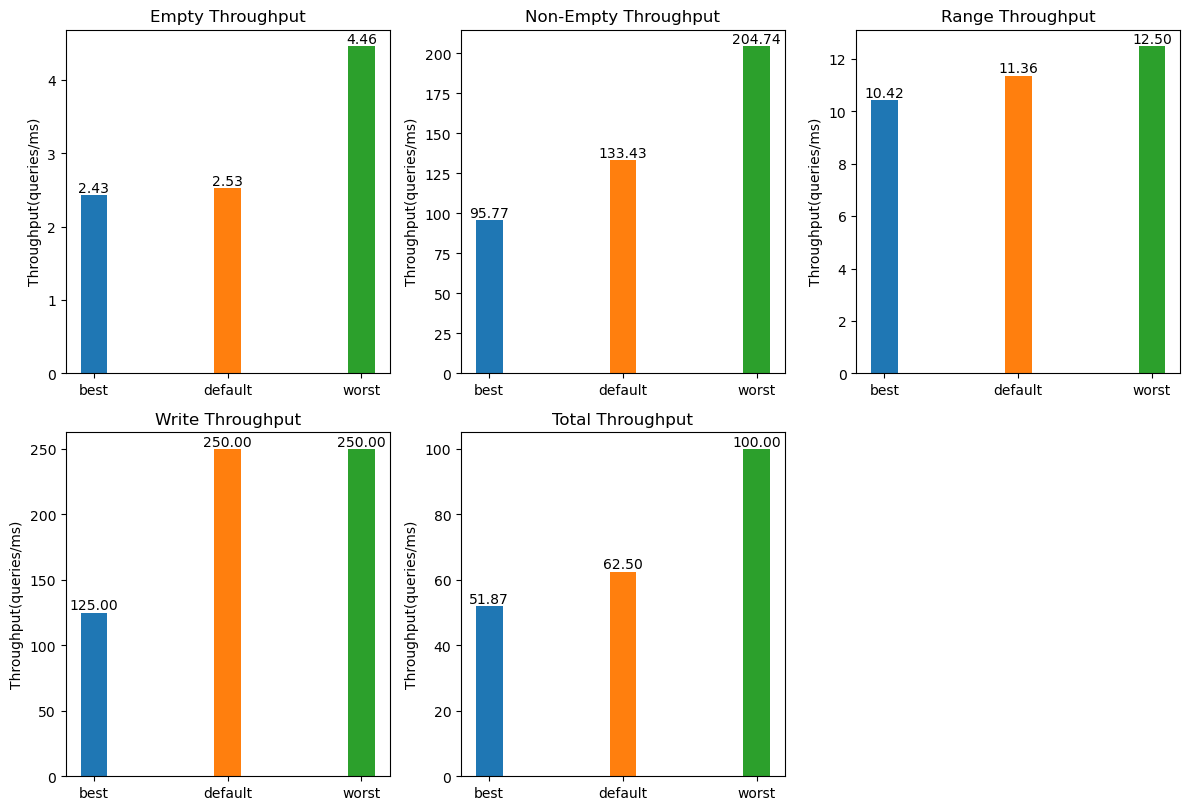

In [88]:
plot_final_hist_evaluation_phase_graph()

In [ ]:
hyper_parameters_integer = {
    "max_open_files":[-1,10000, -1],
    "max_total_wal_size":[0, 100000, 0],
    "delete_obsolete_files_period_micros":[0, 6 * 60 * 60 * 1000000, 6 * 60 * 60 * 1000000],
    "max_background_jobs":[2, 10, 2],
    "max_subcompactions":[1, 100, 1],
    "compaction_readahead_size":[0, 1000000, 0],
    "writable_file_max_buffer_size":[0, 1024 * 1024, 1024 * 1024],
    "delayed_write_rate":[0, 1000000, 0],
    
    "max_write_buffer_number":[1, 10, 2],
    "inplace_update_num_locks":[0, 10000, 0],
    "memtable_huge_page_size":[0, 1000000, 0],
    "arena_block_size":[0, 1000000, 0],
    "level0_slowdown_writes_trigger":[0, 100, 20],
    "level0_stop_writes_trigger":[0, 100, 36],
    "target_file_size_base":[0, 100000000, 64 * 1048576],
    "target_file_size_multiplier":[0, 100, 1],
    "max_compaction_bytes":[0, 1000000000, 64 * 1048576 * 25],
    "soft_pending_compaction_bytes_limit":[0, 1000000000, 64 * 1073741824],
    "hard_pending_compaction_bytes_limit":[0, 1000000000, 256 * 1073741824]                          
}
                                           
hyper_parameters_float ={
    "memtable_prefix_bloom_size_ratio":[0.0, 1.0, 0.0],
    "max_bytes_for_level_multiplier":[0.0, 100.0, 10.0]
}
                                           
hyper_parameters_catagorical ={
    "avoid_flush_during_shutdown":[[True, False],False],  
    "memtable_whole_key_filtering":[[True, False],False],
   "compression_per_level":[["kNoCompression", "kSnappyCompression", "kZlibCompression", "kBZip2Compression", "kLZ4Compression", "kLZ4HCCompression", "kXpressCompression", "kZSTD"], "kNoCompression"]

}

In [ ]:
def plot_no_tuning_graph():
    data_url = '../../build/performance/performance_metrics.csv'
    df = pd.read_csv(data_url, header=None, names=["Empty Reads", "Non-Empty Reads", "Range Reads", "Writes"])
    avg_latency =df.sum().mean()
    fig_empty_reads = px.line(df, x=df.index, y="Empty Reads", title="Empty Reads")
    fig_non_empty_reads = px.line(df, x=df.index, y="Non-Empty Reads", title="Non-Empty Reads")
    fig_range_reads = px.line(df, x=df.index, y="Range Reads", title="Range Reads")
    fig_writes = px.line(df, x=df.index, y="Writes", title="Writes")
    fig_empty_reads.update_xaxes(title_text='Iterations')
    fig_empty_reads.update_yaxes(title_text='Time (ms)')
    fig_non_empty_reads.update_xaxes(title_text='Iterations')
    fig_non_empty_reads.update_yaxes(title_text='Time (ms)')
    fig_range_reads.update_xaxes(title_text='Iterations')
    fig_range_reads.update_yaxes(title_text='Time (ms)')
    fig_writes.update_xaxes(title_text='Iterations')
    fig_writes.update_yaxes(title_text='Time (ms)')


    fig_empty_reads.show()
    fig_non_empty_reads.show()
    fig_range_reads.show()
    fig_writes.show()

    fig_empty_reads.write_image("../../build/performance/empty_reads_graph_no_tuning.png")
    fig_non_empty_reads.write_image("../../build/performance/non_empty_reads_graph_no_tuning.png")
    fig_range_reads.write_image("../../build/performance/range_reads_graph_no_tuning.png")
    fig_writes.write_image("../../build/performance/writes_graph_no_tuning.png")

In [ ]:
plot_no_tuning_graph()